In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_dir = "/content/gdrive/MyDrive/Batik Dataset Enhanched/Batik"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=270,
                                   zoom_range=0.2,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='wrap',
                                   validation_split=0.25)


In [5]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=(224, 224),
                                                         shuffle=False,
                                                         color_mode='rgb',
                                                         class_mode='categorical',
                                                         subset='validation')

Found 761 images belonging to 20 classes.
Found 240 images belonging to 20 classes.


In [12]:
from tensorflow.keras import layers
from tensorflow.keras import Model

base_model = tf.keras.applications.Xception(
    include_top=False, weights='imagenet', pooling="max",
    classifier_activation=None
)

"""for layer in base_model.layers[:-1]:
    model.add(layer)    """

# Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
x = layers.Dense  (20, activation='softmax', kernel_regularizer='l2')(x)           

model = Model(base_model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [13]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["acc"])

In [14]:
class myCallback(tf.keras.callbacks.Callback):
        # Your Code
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('acc')>0.9):
                print("\nReached 90% so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [15]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=500, steps_per_epoch=15, callbacks=[callbacks])

Epoch 1/500
15/15 [==============================] - 284s 19s/step - loss: 4.5858 - acc: 0.1396 - val_loss: 2.9216 - val_acc: 0.2500
Epoch 2/500
15/15 [==============================] - 147s 10s/step - loss: 2.7345 - acc: 0.2708 - val_loss: 2.5551 - val_acc: 0.3250
Epoch 3/500
15/15 [==============================] - 138s 9s/step - loss: 2.3332 - acc: 0.3742 - val_loss: 2.3577 - val_acc: 0.3583
Epoch 4/500
15/15 [==============================] - 138s 9s/step - loss: 2.1426 - acc: 0.4101 - val_loss: 2.3283 - val_acc: 0.4167
Epoch 5/500
15/15 [==============================] - 139s 9s/step - loss: 1.9659 - acc: 0.4771 - val_loss: 2.3292 - val_acc: 0.4000
Epoch 6/500
15/15 [==============================] - 140s 9s/step - loss: 1.9531 - acc: 0.4708 - val_loss: 2.1561 - val_acc: 0.4458
Epoch 7/500
15/15 [==============================] - 147s 10s/step - loss: 1.8397 - acc: 0.4926 - val_loss: 2.3059 - val_acc: 0.4000
Epoch 8/500
15/15 [==============================] - 143s 10s/step - loss

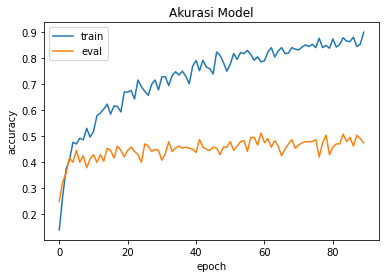

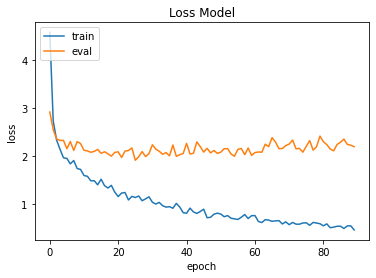

In [16]:
import matplotlib.pyplot as plt

# Accuracy plotting
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

# Loss plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

In [17]:
tf.saved_model.save(model, "Batik Classification V5 - Xception")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: Batik Classification V5 - Xception/assets


In [23]:
!zip -r /content/BatikClassificationV5-Xception.zip /content/BatikClassificationV5-Xception

  adding: content/BatikClassificationV5-Xception/ (stored 0%)
  adding: content/BatikClassificationV5-Xception/saved_model.pb (deflated 92%)
  adding: content/BatikClassificationV5-Xception/variables/ (stored 0%)
  adding: content/BatikClassificationV5-Xception/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/BatikClassificationV5-Xception/variables/variables.index (deflated 79%)
  adding: content/BatikClassificationV5-Xception/assets/ (stored 0%)


In [19]:
label = []
import os
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        label.append(os.path.join(dirname, filename).split('/')[-2])

labels = np.unique(label)
ints = np.arange(0, len(label))
dicts = dict(zip(labels, ints))
dicts

{'batik-bali': 0,
 'batik-betawi': 1,
 'batik-celup': 2,
 'batik-cendrawasih': 3,
 'batik-ceplok': 4,
 'batik-ciamis': 5,
 'batik-garutan': 6,
 'batik-gentongan': 7,
 'batik-kawung': 8,
 'batik-keraton': 9,
 'batik-lasem': 10,
 'batik-megamendung': 11,
 'batik-parang': 12,
 'batik-pekalongan': 13,
 'batik-priangan': 14,
 'batik-sekar-jagad': 15,
 'batik-sidoluhur': 16,
 'batik-sidomukti': 17,
 'batik-sogan': 18,
 'batik-tambal': 19}

In [20]:
y_true = validation_generator.classes

print(y_true)

[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19]


In [21]:
predictions = model.predict(validation_generator)
y_pred = np.rint(predictions)
y_pred = np.argmax(y_pred, axis=1)

print(y_pred)

[ 0  0  0  7  1 13 13  0  3  0  0 13  1  0  1  1  1  1  1  1  0  0  1  1
  0  2  2  2  2  2  2  2  2  2  2  2  0  0  3  0  3  3  7 10  3  0  3 14
  8  4  8  0  0 13  0  0  8  4  0  4 13 17  0  5  8  2  1  0  5  3  0  6
  5  1  0  0  6  5  0  0  8  6  6  0 13  7  0 18  7  0  0  4  5  7 16  0
  8  8  8 17  8  8  8  8  8  8  8  8 10  0 12 12  0  5  1  0  4  0  0  0
  0  0 13 10  0  0  5 13  3  7  0  0 11 11 11 11 11 11 11 11 11 11 11 11
 12  0 12 12 12 12 12 12 12 12 12 12  0 13  0  0 13  0  5 13  5  7 10  5
  0  0  0 14 14 10 12  0  0  0  0  0  0 14  7  0 15 15 19  8 15 15 14 15
 16  0 16 16 16  0 16  0 16  7  0 16 18  8  0 17 18  5  0  5  5  0  0  0
  7  0  8 18  0 18 17  0 14 18 13 18 19  0  4 19 19 19 19 18  0 19 14  4]


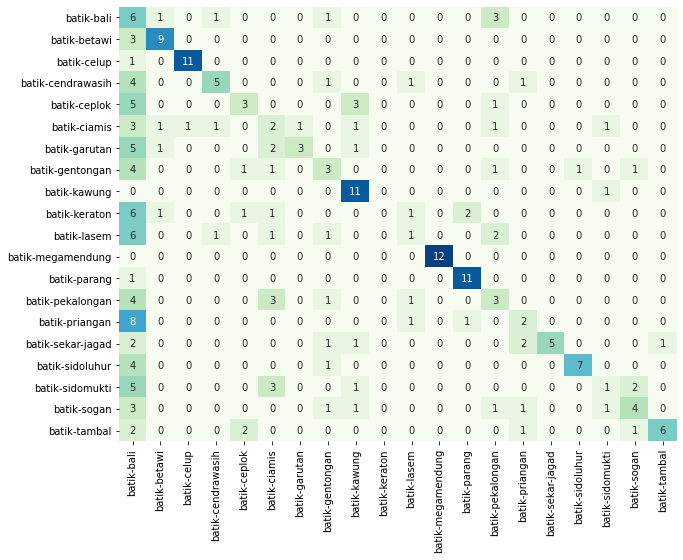

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='GnBu', cbar=False)
plt.xticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=0)
plt.show()

In [24]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.50      0.14        12
           1       0.69      0.75      0.72        12
           2       0.92      0.92      0.92        12
           3       0.62      0.42      0.50        12
           4       0.43      0.25      0.32        12
           5       0.15      0.17      0.16        12
           6       0.75      0.25      0.38        12
           7       0.30      0.25      0.27        12
           8       0.58      0.92      0.71        12
           9       0.00      0.00      0.00        12
          10       0.20      0.08      0.12        12
          11       1.00      1.00      1.00        12
          12       0.79      0.92      0.85        12
          13       0.25      0.25      0.25        12
          14       0.29      0.17      0.21        12
          15       1.00      0.42      0.59        12
          16       0.88      0.58      0.70        12
          17       0.25    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
